This model differs from base model in that it uses only the source data to make a prediction, doesnt remove or transform any variables, no feature engineering

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pwd

'C:\\Users\\Nikhil\\Developer\\Data_Science_Projects\\Titanic Survival'

In [3]:
import xgboost

In [4]:
import sys
 
sys.path.append('C:\\Users\\Nikhil\\Developer\\Data_Science_Projects')
from common_ds_modules import missing_values, data_manipulation, modeling, eda
import os
import pandas as pd
import numpy as np
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p)

from sklearn.compose import make_column_selector as selector
from scipy.stats import skew
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import VotingClassifier

In [5]:
MAX_MODELS = 50

In [6]:
def get_columns(df, query=''):
    return [c for c in df.columns if query.lower() in c.lower()]

In [7]:
def get_pipeline_cross_val_score(preprocessor, model, param_grid, x_train, y_train, scoring_function,max_models=None):
    print(f'Max models: {max_models}')
    if model.__name__ == 'Lasso' or model.__name__ == 'Ridge' or model.__name__ == 'ElasticNet':
        print(f'Scaling Pipe: {model.__name__}')
        pipe = make_pipeline(preprocessor, StandardScaler(), model())
    else:
        pipe = make_pipeline(preprocessor, model())
    
    if max_models is not None:
        random_search = RandomizedSearchCV(pipe, param_grid, scoring=scoring_function,
                                   n_iter=max_models, verbose=0)
    else:
        random_search = GridSearchCV(pipe, param_grid, scoring=scoring_function,
                                   n_iter=max_models, verbose=0)

    random_search = random_search.fit(x_train, y_train)
    best_params = { k.split('__')[1]:v for (k,v) in zip(list(random_search.best_params_.keys()), list(random_search.best_params_.values()))} 
    if model.__name__ == 'Lasso' or model.__name__ == 'Ridge' or model.__name__ == 'ElasticNet':
        print(f'Scaling Final Pipe: {model.__name__}')
        final_pipe = final_pipe = make_pipeline(preprocessor, StandardScaler(), model(**best_params))
    else:
        final_pipe = make_pipeline(preprocessor, model(**best_params))
    
    score = cross_val_score(final_pipe, x_train, y_train, cv=5, scoring=scoring_function).mean()
    
    return final_pipe, score, best_params

In [8]:
xgb_param_grid = {
    'xgbclassifier__n_estimators': [110, 120],
    'xgbclassifier__max_depth':[5,6],
    'xgbclassifier__max_leaves':[40, 30, 50],
    'xgbclassifier__reg_alpha': [i/100 for i in range(1,3)],
    'xgbclassifier__reg_lambda': [i/100 for i in range(1,3)],
    'xgbclassifier__colsample_bytree': [i/10 for i in range(2, 5)],
    'xgbclassifier__learning_rate': [i/100 for i in range(3,6)],
    'xgbclassifier__gamma': [i/100 for i in range(1, 3)]
}

lasso_param_grid = {
    'lasso__alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

ridge_param_grid = {
    'ridge__alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

elastic_net_param_grid = {
    'elasticnet__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'elasticnet__l1_ratio':[0.01, 0.05, 0.1, 0.5, 1]
}

knn_param_grid = {
    'kneighborsclassifier__weights' : ['uniform'],
    'kneighborsclassifier__algorithm' : ['auto'],
    'kneighborsclassifier__n_neighbors' : [5,10,15, 20, 25, 30],
    'kneighborsclassifier__leaf_size': [10],
    'kneighborsclassifier__p': [1],
}

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [10]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
label = 'Survived'
y_train = train_df[label]

id_column = 'PassengerId'
pred_col = f'Predicted_{label}'

In [13]:
numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_df,\
                                                                                            test_df, id_column)                                                                                                  

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [15]:
def plot_variable_dist(df, variables):
    for c in variables:
        print(f'Variable: {c}')
        display(df[c].describe())
        plt.hist(df[c])
        plt.title(f'Distribution for {c}')
        plt.show()
        
def plot_discrete_variable_dist(df, variables):
    for c in variables:
        print(f'Variable: {c}')
        display(df[c].value_counts(normalize=True))
        plt.hist(df[c])
        plt.title(f'Distribution for {c}')
        plt.show()
        
def plot_cat_variable_dist(df, variables):
    for c in variables:
        print(f'Variable: {c}')
        display(df[c].value_counts(normalize=True))
        plt.bar(df[c].value_counts().index, df[c].value_counts())
        plt.title(f'Distribution for {c}')
        plt.show()

In [16]:
def predict(x_train, y_train, x_test, model, id_col_name, id_col, pred_col, label, filename):
    model = model.fit(x_train, y_train)
    test_pred = model.predict(x_test)
    
    x_test[pred_col] = test_pred
    x_test[id_col_name] = id_col
    
    pred = x_test[[id_col_name, pred_col]]
    columns = dict()
    columns[pred_col] = label
    pred = pred.rename(columns=columns)
    pred.to_csv(filename, index=False)

In [17]:
missing_value_df = missing_values.get_variable_missing_values(train_df).reset_index(drop=True).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
10,Cabin,77.104377
5,Age,19.865320
11,Embarked,0.224467
0,PassengerId,0.000000
1,Survived,0.000000
2,Pclass,0.000000
3,Name,0.000000
4,Sex,0.000000
6,SibSp,0.000000
7,Parch,0.000000


In [18]:
train_df2 = train_df.copy()
test_df2 = test_df.copy()

In [19]:
def get_preprocessor(train_df, id_column, label):
    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    categorical_variables, discrete_numerical_variables,\
    continuous_numerical_variables = data_manipulation.get_variables(train_df, [], id_column)
    discrete_numerical_variables = list(set(discrete_numerical_variables) - set([label])) 
    ind_continuous_variables = list(set(continuous_numerical_variables) - set([label]))
    numerical_variables = continuous_numerical_variables + discrete_numerical_variables

    categorical_columns_selector = selector(dtype_exclude='number')
    categorical_columns = categorical_columns_selector(train_df)
    categorical_columns = list(set(categorical_columns) - set([label]))
    #categorical_columns = ['Embarked', 'Ticket', 'Sex', 'Cabin']
    ohe2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
    categorical_pipeline2 = make_pipeline(categorical_imputer, ohe2)
    
    print(f'Continuous Variables: {ind_continuous_variables}')
    print(f'Discrete Numerical Variables: {discrete_numerical_variables}')
    print(f'Categorical Variables: {categorical_columns}')
    
    preprocessor = make_column_transformer((categorical_pipeline2, categorical_columns),
                                           (numerical_imputer, ind_continuous_variables),
                                           (categorical_imputer, discrete_numerical_variables),
                                        )
    return preprocessor

In [20]:
def train_stacking_classifier(train_df, y_train, estimators, final_estimator, scoring_function):
    stacking_classifier = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
        )
    
    score = cross_val_score(stacking_classifier, train_df, y_train, cv=5, scoring=scoring_function).mean()
    print(f'Score: {score}')
    return stacking_classifier, score


In [21]:
def train_classifiers(preprocessor, train_df, y_train, dt_param_grid, rf_param_grid, knn_param_grid, xgb_param_grid,\
                    gbr_param_grid):
    
    dt_final_pipe, dt_score, dt_best_params = get_pipeline_cross_val_score(preprocessor, DecisionTreeClassifier,\
                                            dt_param_grid, train_df, y_train, 'accuracy', 50)
    print(f'DT Score: {dt_score}, dt best params: {dt_best_params}')
    print()
    print()
    
    rf_final_pipe, rf_score, rf_best_params = get_pipeline_cross_val_score(preprocessor, RandomForestClassifier,\
                                                            rf_param_grid, train_df, y_train, 'accuracy', 50)
    print(f'RF Score: {rf_score}, RF best params: {rf_best_params}')
    print()
    print()
    
    knn_final_pipe, knn_score, knn_best_params = get_pipeline_cross_val_score(preprocessor, KNeighborsClassifier,\
                                                knn_param_grid, train_df, y_train, 'accuracy', 50)
    print(f'KNN Score: {knn_score}, KNN best params: {knn_best_params}')
    print()
    print()
    
    xgb_final_pipe, xgb_score, xgb_best_params = get_pipeline_cross_val_score(preprocessor, XGBClassifier, xgb_param_grid,\
                                                train_df, y_train, 'accuracy', 50)
    print(f'XGB Score: {xgb_score}, XGB best params: {xgb_best_params}')
    print()
    print()
    
    gbr_final_pipe, gbr_score, gbr_best_params = get_pipeline_cross_val_score(preprocessor, GradientBoostingClassifier,\
                                                gbr_param_grid, train_df, y_train, 'accuracy', 50)
    print(f'GBR Score: {gbr_score}, GBR best params: {gbr_best_params}')
    print()
    print()
    
    lr_final_pipe = make_pipeline(preprocessor, LogisticRegression())
    lr_score = cross_val_score(lr_final_pipe, train_df, y_train, cv=5, scoring='accuracy').mean()
    print(f'Logistic Regression Score: {lr_score}')
    print()
    print()
    
    return {'DecisionTree': dt_final_pipe, 'RandomForest': rf_final_pipe, 'KNN': knn_final_pipe, 'XGB': xgb_final_pipe,\
            'GBR': gbr_final_pipe, 'LogisticRegression': lr_final_pipe }

Code to train stack classifiers

In [22]:
%%time
dt_param_grid = {
    'decisiontreeclassifier__max_depth':[2,3],
    'decisiontreeclassifier__min_samples_split':[10, 20, 30],
    'decisiontreeclassifier__min_samples_leaf':[10, 20, 30],
    'decisiontreeclassifier__max_features' : ['sqrt'],
    'decisiontreeclassifier__min_impurity_decrease': [i/100 for i in range(1, 3)],
    'decisiontreeclassifier__ccp_alpha': [i/10 for i in range(1, 3)]
}

rf_param_grid = {
    'randomforestclassifier__n_estimators':[100, 500, 1000],
    'randomforestclassifier__min_samples_split':[10, 20, 30, 40, 50],
    'randomforestclassifier__max_depth': [2,3,4,5],
    'randomforestclassifier__min_samples_leaf': [5, 10, 15, 20, 25, 30],
    'randomforestclassifier__min_impurity_decrease': [0.002, 0.004, 0.006, 0.008]
}

knn_param_grid = {
    'kneighborsclassifier__weights' : ['uniform'],
    'kneighborsclassifier__algorithm' : ['auto'],
    'kneighborsclassifier__n_neighbors' : [5,10,15, 20, 25, 30],
    'kneighborsclassifier__leaf_size': [10],
    'kneighborsclassifier__p': [1],
}

xgb_param_grid = {
    'xgbclassifier__n_estimators': [110, 120],
    'xgbclassifier__max_depth':[5,6],
    'xgbclassifier__max_leaves':[40, 30, 50],
    'xgbclassifier__reg_alpha': [i/100 for i in range(1,3)],
    'xgbclassifier__reg_lambda': [i/100 for i in range(1,3)],
    'xgbclassifier__colsample_bytree': [i/10 for i in range(2, 5)],
    'xgbclassifier__learning_rate': [i/100 for i in range(3,6)],
    'xgbclassifier__gamma': [i/100 for i in range(1, 3)]
}

gbr_param_grid = {
    'gradientboostingclassifier__n_estimators': [1000, 1200],
    'gradientboostingclassifier__max_depth':[4,5,6],
    'gradientboostingclassifier__max_leaf_nodes':[40, 30, 50],
    'gradientboostingclassifier__min_samples_split':[40, 30, 50],
    'gradientboostingclassifier__subsample': [i/10 for i in range(2, 5)],
    'gradientboostingclassifier__learning_rate': [i/100 for i in range(3,6)],
    'gradientboostingclassifier__max_features': [i/100 for i in range(1, 3)]
}

CPU times: total: 0 ns
Wall time: 0 ns


#### Base KNN Classifier

In [23]:
#predict(train_df3, y_train, test_df3, knn_final_pipe, id_column, pred_col, label, 'knn_clf_v2.csv')

In [24]:
def get_headers(worksheet, row_index):
    num_rows = worksheet.max_row
    num_cols = worksheet.max_column
    headers = []
    for i in range(row_index, row_index + 1):
        for j in range(1, num_cols + 1):
            cell = worksheet.cell(row=i, column=j)
            if cell.value:
                #print(f'Cell at ({i}, {j}): {cell.value}')
                headers.append(cell.value)
    return headers

change it to use pandas

In [25]:
def save_results(workbook, worksheet_name, data, row_index, workbook_title):
    worksheet = workbook[worksheet_name]
    current_row = worksheet.max_row + 1
    headers = get_headers(worksheet, row_index)
    num_cols = len(headers)
    print(f'Num columns: {num_cols}')
    print(f'current row: {current_row}')
    cell = worksheet.cell(row=current_row - 1, column=1)
    prev_version = 0
    if cell.value != 'Version':
        current_version = cell.value + 1
        current_cell = worksheet.cell(row=current_row, column=1)
        current_cell.value = current_version
    else:
        current_cell = worksheet.cell(row=current_row, column=1)
        current_cell.value = 1
        
    for j in range(2, num_cols + 1):
        cell = worksheet.cell(row=current_row, column=j)
        cell.value = str(list(data.values())[j - 3])
        print(f'Current Row = {current_row}, current column: {j}, cell_value: {cell.value}')
    workbook.save(workbook_title)

In [26]:
def train_classifier(preprocessor, model, hyper_parameter_set, train_df, y_train, scoring_function, max_models,\
                         workbook, worksheet_name, workbook_name):
    
    final_pipe, train_score, best_params = get_pipeline_cross_val_score(preprocessor, model,\
                                            hyper_parameter_set, train_df, y_train, scoring_function, max_models)
    
    data = dict()
    feature_list = list(train_df.columns)
    feature_str = ',\n '.join(feature_list)
    
    print(f'train_score: {train_score}')
    
    #workbook_name = 'Titanic Survival Model.xlsx'
    sheet = pd.read_excel(workbook_name, sheet_name=worksheet_name).rename(columns=lambda x: x.strip())
    
    if len(sheet) > 0:
        old_version = sheet.loc[len(sheet) - 1, 'Version']
        new_version = old_version + 1
    else:
        new_version = 1
        
    public_score = 0
    sheet.loc[len(sheet)] = [new_version, feature_str, hyper_parameter_set, best_params, train_score, public_score] # row

    with pd.ExcelWriter(workbook_name,
                        mode='a', if_sheet_exists='replace') as writer:  
        sheet.to_excel(writer, sheet_name=worksheet_name, index=False)
    #row_index = 1
    #save_results(workbook, worksheet_name, data, row_index, workbook_name)
    
    return final_pipe

In [27]:
def get_columns(obj, query=''):
    for field in dir(obj):
        if field[0:2] != '__' and field[0] != '_':
            if query.lower() in field.lower():
                print(f'Field: {field}')

In [28]:
def get_categorical_columns(train_df, label):
    categorical_columns_selector = selector(dtype_exclude='number')
    categorical_columns = categorical_columns_selector(train_df)
    categorical_columns = list(set(categorical_columns) - set([label]))
    
    return categorical_columns

In [29]:
def get_numerical_variables(train_df, id_column, label):
    categorical_variables, discrete_numerical_variables,\
    continuous_numerical_variables = data_manipulation.get_variables(train_df, [], id_column)
    discrete_numerical_variables = list(set(discrete_numerical_variables) - set([label])) 
    ind_continuous_variables = list(set(continuous_numerical_variables) - set([label]))
    
    return ind_continuous_variables, discrete_numerical_variables

In [30]:
ind_continuous_variables, discrete_numerical_variables = get_numerical_variables(train_df2, id_column, label)
categorical_columns = get_categorical_columns(train_df2, label)

In [31]:
variables = categorical_columns + ind_continuous_variables + discrete_numerical_variables
train_df3 = train_df2[variables]
test_df3 = test_df2[variables]
test_df3[id_column] = test_df2[id_column]

In [32]:
preprocessor = get_preprocessor(train_df3, id_column, label)

Continuous Variables: ['Fare', 'Age']
Discrete Numerical Variables: ['SibSp', 'Parch', 'Pclass']
Categorical Variables: ['Cabin', 'Name', 'Embarked', 'Ticket', 'Sex']


In [33]:
workbook = 'useless variable'

In [34]:
%%time
dt_final_pipe = train_classifier(preprocessor, DecisionTreeClassifier, dt_param_grid, train_df3, y_train, 'accuracy', 50,\
                         workbook, 'DecisionTree', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.6161634548992531
CPU times: total: 4.36 s
Wall time: 7.48 s


In [35]:
%%time
rf_final_pipe = train_classifier(preprocessor, RandomForestClassifier, rf_param_grid, train_df3, y_train, 'accuracy', 50,\
                         workbook, 'RandomForest', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.6161634548992531
CPU times: total: 2min 3s
Wall time: 3min


In [36]:
%%time
knn_final_pipe = train_classifier(preprocessor, KNeighborsClassifier, knn_param_grid, train_df3, y_train, 'accuracy', 50,\
                         workbook, 'KNN', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.746368715083799
CPU times: total: 5.91 s
Wall time: 4.35 s


In [37]:
%%time
gbr_final_pipe = train_classifier(preprocessor, GradientBoostingClassifier, gbr_param_grid, train_df3, y_train, 'accuracy', 50,\
                         workbook, 'GBRClassifier', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.8271357730211537
CPU times: total: 2min 29s
Wall time: 3min 41s


In [38]:
%%time
xgb_final_pipe = train_classifier(preprocessor, XGBClassifier, xgb_param_grid, train_df3, y_train, 'accuracy', 50,\
                         workbook, 'XGBClassifier', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.8339150084740444
CPU times: total: 8min 16s
Wall time: 1min 19s


### Feature Engineering Round 1

In [39]:
def is_married(x):
    return 1 if 'mrs.' in x['Name'].lower() and x['Sex'] == 'female' else 0

def get_title(x):
    return x.split(', ')[1].split(' ')[0]

def get_age_group(age): # based on training data EDA
    if age < 30:
        return 0
    else:
        return 1
    
def convert_title(title):
    if title not in ['Mr.', 'Miss.', 'Mrs.', 'Master']:
        return 'other'
    else:
        return title

In [40]:
train_df4 = pd.read_csv('train.csv')
test_df4 = pd.read_csv('test.csv')

In [41]:
train_df4['is_married'] = train_df4.apply(lambda x: is_married(x), axis='columns')
train_df4['title'] = train_df4['Name'].apply(lambda x: get_title(x))
train_df4['title_converted'] = train_df4['title'].apply(lambda x: convert_title(x))
train_df4['sex_converted'] = train_df4['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df4['age_group'] = train_df4['Age'].apply(lambda x: get_age_group(x))
train_df4['family_size'] = train_df4['Parch'] + train_df4['SibSp']
train_df4['solo_traveler'] = train_df4['family_size'].apply(lambda x: 1 if x == 0 else 0)

In [42]:
test_df4['is_married'] = test_df4.apply(lambda x: is_married(x), axis='columns')
test_df4['title'] = test_df4['Name'].apply(lambda x: get_title(x))
test_df4['title_converted'] = test_df4['title'].apply(lambda x: convert_title(x))
test_df4['sex_converted'] = test_df4['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test_df4['age_group'] = test_df4['Age'].apply(lambda x: get_age_group(x))
test_df4['family_size'] = test_df4['Parch'] + test_df4['SibSp']
test_df4['solo_traveler'] = test_df4['family_size'].apply(lambda x: 1 if x == 0 else 0)

In [43]:
nec_variables = ['Pclass', 'Embarked', 'Fare','is_married', 'title_converted', 'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler', 'Parch', 'SibSp']

In [44]:
train_df5 = train_df4[nec_variables]
test_df5 = test_df4[nec_variables]
y_train = train_df[label]

In [45]:
preprocessor2 = get_preprocessor(train_df5, id_column, label)

Continuous Variables: ['Fare', 'Age']
Discrete Numerical Variables: ['Parch', 'solo_traveler', 'family_size', 'sex_converted', 'SibSp', 'is_married', 'age_group', 'Pclass']
Categorical Variables: ['title_converted', 'Embarked']


In [46]:
#len(['Fare', 'Age'] + ['is_married', 'solo_traveler', 'sex_converted', 'family_size', 'SibSp', 'age_group', 'Pclass', 'Parch'] + ['Embarked', 'title_converted'])

In [47]:
ls t*.xlsx

 Volume in drive C is OS
 Volume Serial Number is 300E-5120

 Directory of C:\Users\Nikhil\Developer\Data_Science_Projects\Titanic Survival

03/10/2024  09:40 AM            35,933 Titanic Survival Model.xlsx
               1 File(s)         35,933 bytes
               0 Dir(s)  288,542,973,952 bytes free


In [48]:
%%time
dt_final_pipe = train_classifier(preprocessor2, DecisionTreeClassifier, dt_param_grid, train_df5, y_train, 'accuracy', 50,\
                         workbook, 'DecisionTree', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.7451886259494068
CPU times: total: 2.44 s
Wall time: 3.74 s


In [49]:
%%time
rf_final_pipe = train_classifier(preprocessor2, RandomForestClassifier, rf_param_grid, train_df5, y_train, 'accuracy', 50,\
                         workbook, 'RandomForest', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.8215115184232001
CPU times: total: 1min 37s
Wall time: 2min 22s


In [50]:
%%time
knn_final_pipe = train_classifier(preprocessor2, KNeighborsClassifier, knn_param_grid, train_df5, y_train, 'accuracy', 50,\
                         workbook, 'KNN', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.7497520557403805
CPU times: total: 1.05 s
Wall time: 1.26 s


In [51]:
%%time
xgb_final_pipe = train_classifier(preprocessor2, XGBClassifier, xgb_param_grid, train_df5, y_train, 'accuracy', 50,\
                         workbook, 'XGBClassifier', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.8372732408511707
CPU times: total: 1min 46s
Wall time: 16.9 s


In [52]:
%%time
gbr_final_pipe = train_classifier(preprocessor2, GradientBoostingClassifier, gbr_param_grid, train_df5, y_train, 'accuracy', 50,\
                         workbook, 'GBRClassifier', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.8226790534178645
CPU times: total: 2min 4s
Wall time: 2min 51s


In [54]:
lr_final_pipe = make_pipeline(preprocessor2, LogisticRegression())

estimators = [
        ('LogisticRegression', lr_final_pipe),
         ('KNN', knn_final_pipe),
        ('RandomForest', rf_final_pipe),
        ('GradientBoostingClassifier', gbr_final_pipe),
        ('XGBClassifier', xgb_final_pipe)
]

In [55]:
rf_final_estimator = RandomForestClassifier()
xgb_final_estimator = XGBClassifier()

In [56]:
rf_stack, rf_stack_score = train_stacking_classifier(train_df5, y_train, estimators, rf_final_estimator, 'accuracy')
#predict(train_df5, y_train, test_df5, rf_stack, id_column,test_df[id_column], pred_col, label, 'rf_stack_feat_1.csv')

Score: 0.8024919967359236


In [57]:
xgb_stack, xgb_stack_score = train_stacking_classifier(train_df5, y_train, estimators, xgb_final_estimator, 'accuracy')
xgb_stack_score

Score: 0.7811562362689095


0.7811562362689095

In [58]:
predict(train_df5, y_train, test_df5, xgb_stack, id_column, test_df[id_column], pred_col, label, 'xgb_stack_feat_1.csv')

### Voting

In [59]:
vote_rf = VotingClassifier(estimators=[('LogisticRegression', lr_final_pipe),\
                                         ('KNN', knn_final_pipe),
                                         ('RF', rf_final_pipe),
                                        ('GBR', gbr_final_pipe),
                                        ('XGB', xgb_final_pipe)], voting='hard')

score = cross_val_score(vote_rf, train_df5, y_train, cv=5, scoring='accuracy').mean()

print(f'Voting Classifier with RF score: {score}')

Voting Classifier with RF score: 0.8305191136777352


In [60]:
predict(train_df5, y_train, test_df5, vote_rf, id_column, test_df[id_column], pred_col, label, 'vote_rf_feat_1.csv')

In [61]:
train_df5.columns

Index(['Pclass', 'Embarked', 'Fare', 'is_married', 'title_converted',
       'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler',
       'Parch', 'SibSp'],
      dtype='object')

In [62]:
 estimators_no_rf = [
        ('LogisticRegression', lr_final_pipe),
         ('KNN', knn_final_pipe),
        ('GradientBoostingClassifier', gbr_final_pipe),
        ('XGBClassifier', xgb_final_pipe)
]

In [63]:
rf_stack_no_rf, rf_stack_score = train_stacking_classifier(train_df5, y_train, estimators_no_rf, rf_final_estimator, 'accuracy')

Score: 0.7901324461741259


In [64]:
xgb_stack_no_rf, xgb_stack_score = train_stacking_classifier(train_df5, y_train, estimators_no_rf, xgb_final_estimator, 'accuracy')


Score: 0.7800514719728832


In [65]:
predict(train_df5, y_train, test_df5, rf_stack_no_rf, id_column,test_df[id_column], pred_col, label, 'rf_stack_no_rf_feat_1.csv')

In [66]:
predict(train_df5, y_train, test_df5, xgb_stack_no_rf, id_column,test_df[id_column], pred_col, label, 'xgb_stack_no_rf_feat_1.csv')

In [67]:
vote_no_rf = VotingClassifier(estimators=[('LogisticRegression', lr_final_pipe),\
                                         ('KNN', knn_final_pipe),
                                        ('GBR', gbr_final_pipe),
                                        ('XGB', xgb_final_pipe)], voting='hard')

score = cross_val_score(vote_no_rf, train_df5, y_train, cv=5, scoring='accuracy').mean()

print(f'Voting Classifier with no RF score: {score}')

Voting Classifier with no RF score: 0.8316427091833531


In [68]:
predict(train_df5, y_train, test_df5, vote_no_rf, id_column, test_df[id_column], pred_col, label, 'vote_no_rf_feat_1.csv')

In [69]:
train_df5.columns

Index(['Pclass', 'Embarked', 'Fare', 'is_married', 'title_converted',
       'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler',
       'Parch', 'SibSp'],
      dtype='object')

In [70]:
train_df6 = train_df4[nec_variables + ['Name', 'Ticket', 'Cabin']]
test_df6 = test_df4[nec_variables + ['Name', 'Ticket', 'Cabin']]
y_train = train_df[label]

In [106]:
preprocessor3 = get_preprocessor(train_df6, id_column, label)

Continuous Variables: ['Fare', 'Age']
Discrete Numerical Variables: ['Predicted_Survived', 'Parch', 'solo_traveler', 'family_size', 'sex_converted', 'SibSp', 'is_married', 'age_group', 'Pclass']
Categorical Variables: ['Cabin', 'Name', 'title_converted', 'Embarked', 'Ticket']


#### Using all variables

In [107]:
'Survived' in train_df6.columns

True

In [104]:
%%time
dt_final_pipe = train_classifier(preprocessor3, DecisionTreeClassifier, dt_param_grid, train_df6, y_train, 'accuracy', 50,\
                         workbook, 'DecisionTree', 'Titanic Survival Model.xlsx')

rf_final_pipe = train_classifier(preprocessor3, RandomForestClassifier, rf_param_grid, train_df6, y_train, 'accuracy', 50,\
                         workbook, 'RandomForest', 'Titanic Survival Model.xlsx')

knn_final_pipe = train_classifier(preprocessor3, KNeighborsClassifier, knn_param_grid, train_df6, y_train, 'accuracy', 50,\
                         workbook, 'KNN', 'Titanic Survival Model.xlsx')

xgb_final_pipe = train_classifier(preprocessor3, XGBClassifier, xgb_param_grid, train_df6, y_train, 'accuracy', 50,\
                         workbook, 'XGBClassifier', 'Titanic Survival Model.xlsx')

gbr_final_pipe = train_classifier(preprocessor3, GradientBoostingClassifier, gbr_param_grid, train_df6, y_train, 'accuracy', 50,\
                         workbook, 'GBRClassifier', 'Titanic Survival Model.xlsx')

Max models: 50
train_score: 0.6161634548992531
Max models: 50
train_score: 0.6161634548992531
Max models: 50
train_score: 0.7564873517042245
Max models: 50


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x00000215842D4110>>
Traceback (most recent call last):
  File "C:\Users\Nikhil\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
"""
Max models: 50
train_score: 0.6161634548992531
Max models: 50
train_score: 0.6161634548992531
Max models: 50
train_score: 0.7564873517042245
Max models: 50
train_score: 0.8395267089322704
Max models: 50
train_score: 0.824938798568828
CPU times: total: 12min 57s
Wall time: 6min 59s
"""

In [73]:
lr_final_pipe = make_pipeline(preprocessor3, LogisticRegression())

In [74]:
 estimators = [
        ('LogisticRegression', lr_final_pipe),
         ('KNN', knn_final_pipe),
        ('RandomForest', rf_final_pipe),
        ('GradientBoostingClassifier', gbr_final_pipe),
        ('XGBClassifier', xgb_final_pipe)
]

In [75]:
rf_final_estimator = RandomForestClassifier()
xgb_final_estimator = XGBClassifier()

In [76]:
rf_stack, rf_stack_score = train_stacking_classifier(train_df6, y_train, estimators, rf_final_estimator, 'accuracy')

Score: 0.8047266336074321


In [77]:
predict(train_df6, y_train, test_df6, rf_stack, id_column, test_df[id_column], pred_col, label, 'rf_stack_feat_2.csv')

In [78]:
vote_rf = VotingClassifier(estimators=[('LogisticRegression', lr_final_pipe),\
                                         ('KNN', knn_final_pipe),
                                           ('RF', rf_final_pipe),
                                        ('GBR', gbr_final_pipe),
                                        ('XGB', xgb_final_pipe)], voting='hard')

score = cross_val_score(vote_rf, train_df6, y_train, cv=5, scoring='accuracy').mean()

print(f'Voting Classifier with RF score: {score}')

Voting Classifier with RF score: 0.8316364321134895


In [109]:
vote_rf = vote_rf.fit(train_df6, y_train)
train_df6['Predicted_Survived'] = vote_rf.predict(train_df6)

In [111]:
train_df6.columns

Index(['Pclass', 'Embarked', 'Fare', 'is_married', 'title_converted',
       'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler',
       'Parch', 'SibSp', 'Name', 'Ticket', 'Cabin', 'Predicted_Survived',
       'Survived'],
      dtype='object')

In [80]:
pred_col, label

('Predicted_Survived', 'Survived')

In [108]:
train_df6.shape[0] - errors.shape[0]

819

In [110]:
train_df6[label] = train_df[label]
errors = train_df6[train_df6[pred_col] != train_df6[label]]
errors.shape # (72, 17)

(72, 17)

<Axes: >

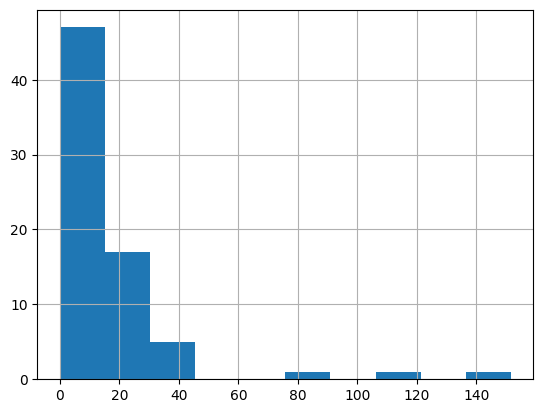

In [82]:
errors['Fare'].hist()

In [83]:
train_df.shape

(891, 12)

In [84]:
predict(train_df6, y_train, test_df6, vote_rf, id_column, test_df[id_column], pred_col, label, 'vote_feat_2.csv')

In [85]:
train_df6.columns

Index(['Pclass', 'Embarked', 'Fare', 'is_married', 'title_converted',
       'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler',
       'Parch', 'SibSp', 'Name', 'Ticket', 'Cabin', 'Predicted_Survived',
       'Survived'],
      dtype='object')

In [86]:
feature_list = list(train_df6.columns)
feature_str = ',\n '.join(feature_list)
feature_str

'Pclass,\n Embarked,\n Fare,\n is_married,\n title_converted,\n sex_converted,\n age_group,\n Age,\n family_size,\n solo_traveler,\n Parch,\n SibSp,\n Name,\n Ticket,\n Cabin,\n Predicted_Survived,\n Survived'

In [87]:
train_df6.columns

Index(['Pclass', 'Embarked', 'Fare', 'is_married', 'title_converted',
       'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler',
       'Parch', 'SibSp', 'Name', 'Ticket', 'Cabin', 'Predicted_Survived',
       'Survived'],
      dtype='object')

Creating new features adding: 'fare_group', 'ticket_prefix_cleaned', 'ticket_numeric', 'ticket_numeric_length', 'ticket_group_size', 'num_cabins'

In [88]:
eng_features = [c for c in train_df6.columns if '_' in c]

In [89]:
eng_features

['is_married',
 'title_converted',
 'sex_converted',
 'age_group',
 'family_size',
 'solo_traveler',
 'Predicted_Survived']

In [90]:
fare_bins = [ 0., 7.85, 10.5, 21.68, 39.69, 512.33]

In [91]:
1.01**100

2.7048138294215285

In [92]:
train_df7 = train_df6.copy()
test_df7 = test_df6.copy()

In [93]:
def get_ticket_info(row):
    has_code = False
    for i in row:
        if i.isalpha():
            has_code = True
    return has_code

In [94]:
def get_num_cabins(x):
    global errors
    if not pd.isnull(x):
        try:
            return len(x.split(' '))
        except:
            #print(f"Cabins {x}")
            errors.add(x)
    else:
        return None

Feature Engineering Round 2

In [95]:
train_df7['ticket_code'] = train_df7['Ticket'].apply(lambda row: get_ticket_info(row))
train_df7['ticket_prefix'] = train_df7['Ticket'].apply(lambda x: x.split(' ')[0] if ' ' in x else 'NONE')

train_df7['ticket_prefix_cleaned'] = train_df7.apply(lambda row: row['ticket_prefix']\
                                      .replace('.', '').replace('/', '') if row['ticket_code'] else row['ticket_prefix'],\
                                       axis='columns')
train_df7['ticket_numeric'] = train_df7['Ticket'].apply(lambda x: x.split()[1] if ' ' in x else x)
train_df7['ticket_numeric_length'] = train_df7['ticket_numeric'].apply(lambda x: len(x))
train_df7['fare_group'] = pd.cut(train_df7['Fare'], fare_bins, labels=[0, 1, 2, 3, 4])

ticket_group_sizes = pd.DataFrame(train_df7['Ticket'].value_counts()).reset_index()
ticket_group_sizes = ticket_group_sizes.rename(columns={'count': 'ticket_group_size'})

train_df7 = train_df7.merge(ticket_group_sizes, on='Ticket')
train_df7["num_cabins"] = train_df7["Cabin"].apply(lambda x: get_num_cabins(x))


In [96]:
train_df7.columns

Index(['Pclass', 'Embarked', 'Fare', 'is_married', 'title_converted',
       'sex_converted', 'age_group', 'Age', 'family_size', 'solo_traveler',
       'Parch', 'SibSp', 'Name', 'Ticket', 'Cabin', 'Predicted_Survived',
       'Survived', 'ticket_code', 'ticket_prefix', 'ticket_prefix_cleaned',
       'ticket_numeric', 'ticket_numeric_length', 'fare_group',
       'ticket_group_size', 'num_cabins'],
      dtype='object')

Feature Engineering on Test

In [97]:
test_df7['ticket_code'] = test_df7['Ticket'].apply(lambda row: get_ticket_info(row))
test_df7['ticket_prefix'] = test_df7['Ticket'].apply(lambda x: x.split(' ')[0] if ' ' in x else 'NONE')

test_df7['ticket_prefix_cleaned'] = test_df7.apply(lambda row: row['ticket_prefix']\
                                      .replace('.', '').replace('/', '') if row['ticket_code'] else row['ticket_prefix'],\
                                       axis='columns')
test_df7['ticket_numeric'] = test_df7['Ticket'].apply(lambda x: x.split()[1] if ' ' in x else x)
test_df7['ticket_numeric_length'] = test_df7['ticket_numeric'].apply(lambda x: len(x))
test_df7['fare_group'] = pd.cut(test_df7['Fare'], fare_bins, labels=[0, 1, 2, 3, 4])

ticket_group_sizes = pd.DataFrame(test_df7['Ticket'].value_counts()).reset_index()
ticket_group_sizes = ticket_group_sizes.rename(columns={'count': 'ticket_group_size'})

test_df7 = test_df7.merge(ticket_group_sizes, on='Ticket')
test_df7["num_cabins"] = test_df7["Cabin"].apply(lambda x: get_num_cabins(x))

In [98]:
new_features = ['fare_group', 'ticket_prefix_cleaned', 'ticket_numeric',\
                'ticket_numeric_length', 'ticket_group_size', 'num_cabins']

In [99]:
feat_eng2 = list(train_df6.columns) + new_features
feat_eng2

['Pclass',
 'Embarked',
 'Fare',
 'is_married',
 'title_converted',
 'sex_converted',
 'age_group',
 'Age',
 'family_size',
 'solo_traveler',
 'Parch',
 'SibSp',
 'Name',
 'Ticket',
 'Cabin',
 'Predicted_Survived',
 'Survived',
 'fare_group',
 'ticket_prefix_cleaned',
 'ticket_numeric',
 'ticket_numeric_length',
 'ticket_group_size',
 'num_cabins']

In [100]:
train_df7.isna().sum()

Pclass                     0
Embarked                   2
Fare                       0
is_married                 0
title_converted            0
sex_converted              0
age_group                  0
Age                      177
family_size                0
solo_traveler              0
Parch                      0
SibSp                      0
Name                       0
Ticket                     0
Cabin                    687
Predicted_Survived         0
Survived                   0
ticket_code                0
ticket_prefix              0
ticket_prefix_cleaned      0
ticket_numeric             0
ticket_numeric_length      0
fare_group                15
ticket_group_size          0
num_cabins               687
dtype: int64

In [101]:
'Cabin' in train_df6.columns

True

In [103]:
feat_eng2

['Pclass',
 'Embarked',
 'Fare',
 'is_married',
 'title_converted',
 'sex_converted',
 'age_group',
 'Age',
 'family_size',
 'solo_traveler',
 'Parch',
 'SibSp',
 'Name',
 'Ticket',
 'Cabin',
 'Predicted_Survived',
 'Survived',
 'fare_group',
 'ticket_prefix_cleaned',
 'ticket_numeric',
 'ticket_numeric_length',
 'ticket_group_size',
 'num_cabins']

In [102]:
train_df8 = train_df7[feat_eng2]
test_df8 = test_df7[feat_eng2]

KeyError: "['Survived'] not in index"

In [ ]:
preprocessor4 = get_preprocessor(train_df8, id_column, label)

In [ ]:
%%time
dt_final_pipe = train_classifier(preprocessor4, DecisionTreeClassifier, dt_param_grid, train_df8, y_train, 'accuracy', 50,\
                         workbook, 'DecisionTree', 'Titanic Survival Model.xlsx')

rf_final_pipe = train_classifier(preprocessor4, RandomForestClassifier, rf_param_grid, train_df8, y_train, 'accuracy', 50,\
                         workbook, 'RandomForest', 'Titanic Survival Model.xlsx')

knn_final_pipe = train_classifier(preprocessor4, KNeighborsClassifier, knn_param_grid, train_df8, y_train, 'accuracy', 50,\
                         workbook, 'KNN', 'Titanic Survival Model.xlsx')

xgb_final_pipe = train_classifier(preprocessor4, XGBClassifier, xgb_param_grid, train_df8, y_train, 'accuracy', 50,\
                         workbook, 'XGBClassifier', 'Titanic Survival Model.xlsx')

gbr_final_pipe = train_classifier(preprocessor4, GradientBoostingClassifier, gbr_param_grid, train_df8, y_train, 'accuracy', 50,\
                         workbook, 'GBRClassifier', 'Titanic Survival Model.xlsx')

In [ ]:
set(train_df6.columns) - set(train_df8.columns)

In [ ]:
lr_final_pipe = make_pipeline(preprocessor4, LogisticRegression())

estimators = [
        ('LogisticRegression', lr_final_pipe),
         ('KNN', knn_final_pipe),
        ('RandomForest', rf_final_pipe),
        ('GradientBoostingClassifier', gbr_final_pipe),
        ('XGBClassifier', xgb_final_pipe),\
]

In [ ]:
vote_rf = VotingClassifier(estimators=[('LogisticRegression', lr_final_pipe),\
                                         ('KNN', knn_final_pipe),
                                           ('RF', rf_final_pipe),
                                        ('GBR', gbr_final_pipe),
                                        ('XGB', xgb_final_pipe)], voting='hard')

score = cross_val_score(vote_rf, train_df8, y_train, cv=5, scoring='accuracy').mean()

print(f'Voting Classifier with RF score: {score}')

In [ ]:
predict(train_df8, y_train, test_df8, vote_rf, id_column, test_df[id_column], pred_col, label, 'vote_rf_feat_3.csv')

In [ ]:
set(train_df8.columns) - set(train_df6.columns)